# longonly_summary

This notebook summarises major performance statistics for long-only futures contracts provided by Quandl.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from adagio.stats.performance import Performance, PerfStats
from adagio.utils import keys
from adagio.utils.const import FuturesInfo
from adagio.utils.mongo import get_library

First, connect to the arctic library named "longonly" to retrieve long-only data.

In [2]:
library = get_library(keys.backtest)

Let's see major statistics for each contract. This is done by looping over all futures contracts saved in the db.

In [3]:
results = []
for fut in FuturesInfo:
    key, futures_info = fut.name, fut.value
    
    symbol = library.list_symbols(lo_ticker=key)[0]
    item = library.read(symbol)
    data = item.data
    
    longonly_returns = data.final_net_returns
    stats = longonly_returns.add(1).cumprod().pipe(Performance).summary()
    
    results.append([
            futures_info.full_name,
            futures_info.asset_class,
            longonly_returns.index[0].strftime("%Y%m%d"),
            stats.loc[PerfStats.ANN_RETURN.value, longonly_returns.name],
            stats.loc[PerfStats.ANN_VOL.value, longonly_returns.name],
            stats.loc[PerfStats.SHARPE.value, longonly_returns.name],
            stats.loc[PerfStats.SKEWNESS.value, longonly_returns.name]
        ])
    
result = pd.DataFrame(results, columns=[
        "contract", "asset class", "start date",
        PerfStats.ANN_RETURN.value, 
        PerfStats.ANN_VOL.value,
        PerfStats.SHARPE.value,
        PerfStats.SKEWNESS.value,
]).set_index("contract")

# Long-only summary

This table displays contract information such as the contract name as well as statistics. Stats are for 1st contracts rolled a few days before its delivery. Bar charts are superimposed for annualised returns and Sharpe ratios based on its value.   Statistics are based on its local currencies.
Note that some start dates do not match the exact inception of the futures contract. Those may be truncated due to the data limitation of Quandl.

In [4]:
(result.style.format({
        PerfStats.ANN_RETURN.value: "{:.2%}",
        PerfStats.ANN_VOL.value: "{:.2%}",
        PerfStats.SHARPE.value: "{:.2f}",
        PerfStats.SKEWNESS.value: "{:.2f}",
    })
 .bar(subset=PerfStats.ANN_RETURN.value)
 .bar(subset=PerfStats.SHARPE.value))

,asset class,start date,annualised return,annualised vol,Sharpe ratio,skewness
contract,,,,,,
E-mini S&P 500 Index,equity_futures,19970909,5.91%,19.62%,0.30,0.10
Full-size S&P 500 Index,equity_futures,19820421,8.58%,19.10%,0.45,-1.07
E-mini NASDAQ 100 Index,equity_futures,19990621,7.50%,28.25%,0.27,0.29
Full-size NASDAQ 100 Index,equity_futures,19980102,11.05%,30.11%,0.37,0.23
Full-size Dow Jones,equity_futures,19971006,5.87%,19.26%,0.30,0.34
S&P 400 MidCap Index,equity_futures,19920213,10.03%,20.16%,0.50,-0.26
Russell 1000,equity_futures,20070921,7.93%,20.95%,0.38,0.14
Russell Small-Cap,equity_futures,20060915,10.25%,25.71%,0.40,-0.13
Russell Value,equity_futures,20100430,11.44%,15.78%,0.72,-0.32


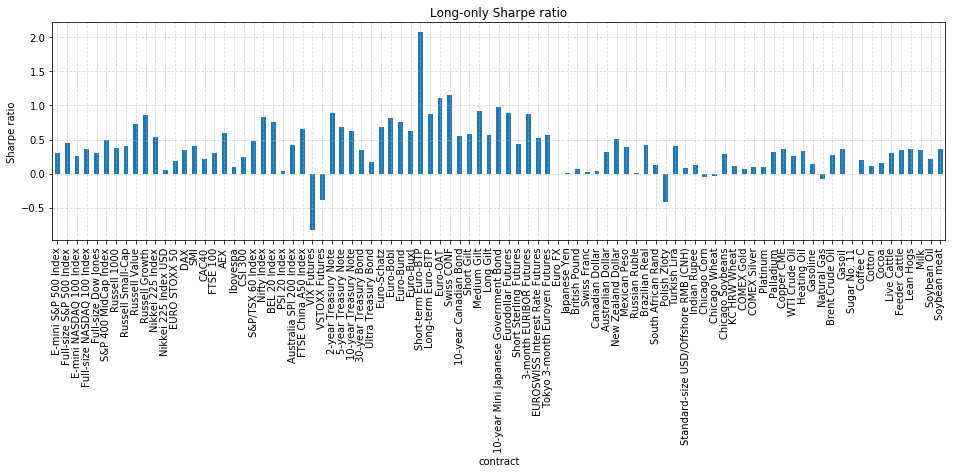

In [5]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.set_title("Long-only Sharpe ratio")
ax.set_ylabel("Sharpe ratio")
result[PerfStats.SHARPE.value].plot(kind="bar", ax=ax, grid=True);

# Plot cumulative return series

Here only E-mini futures is shown.

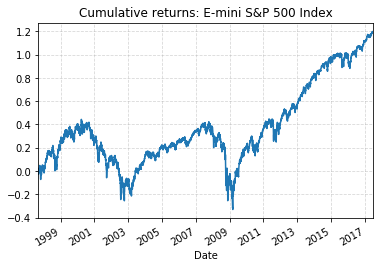

In [6]:
for fut in FuturesInfo:
    symbol = library.list_symbols(lo_ticker=fut.name)[0]
    item = library.read(symbol)
    data = item.data
    
    fig, ax = plt.subplots()
    data.final_net_returns.cumsum().plot(grid=True, ax=ax);
    ax.set_title('Cumulative returns: {}'.format(fut.value.full_name))
    
    break